<p>Description: This code produces a four panel plot displaying GOES16 Day-Snow-Fog products. For a quick-guide to this product, please see:</p>
<a href='http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_DaySnowFog.pdf'>VISIT Day-Snow-Cloud Guide</a>
<p>Satpy is used to plot and create the composites. The Day-Snow-Fog product is not natively included. A custom composite and enhancement profile must be included as follows:</p>

Note that ranges (stretch) and gamma settings are modified from the suggested settings in the VISIT guide. This is to acount for the large solar zenith angle present during this time of year at the latitude of the study. The modifications slightly improve the contrast and increase the brightness of the composites. 

The following datasets were not created and may require resampling to be generated: DatasetID(name='blsn', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
The following datasets were not created and may require resampling to be generated: DatasetID(name='blsn', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
The following datasets were not created and may require resampling to be generated: DatasetID(name='blsn', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
The following datasets were not created and may requ

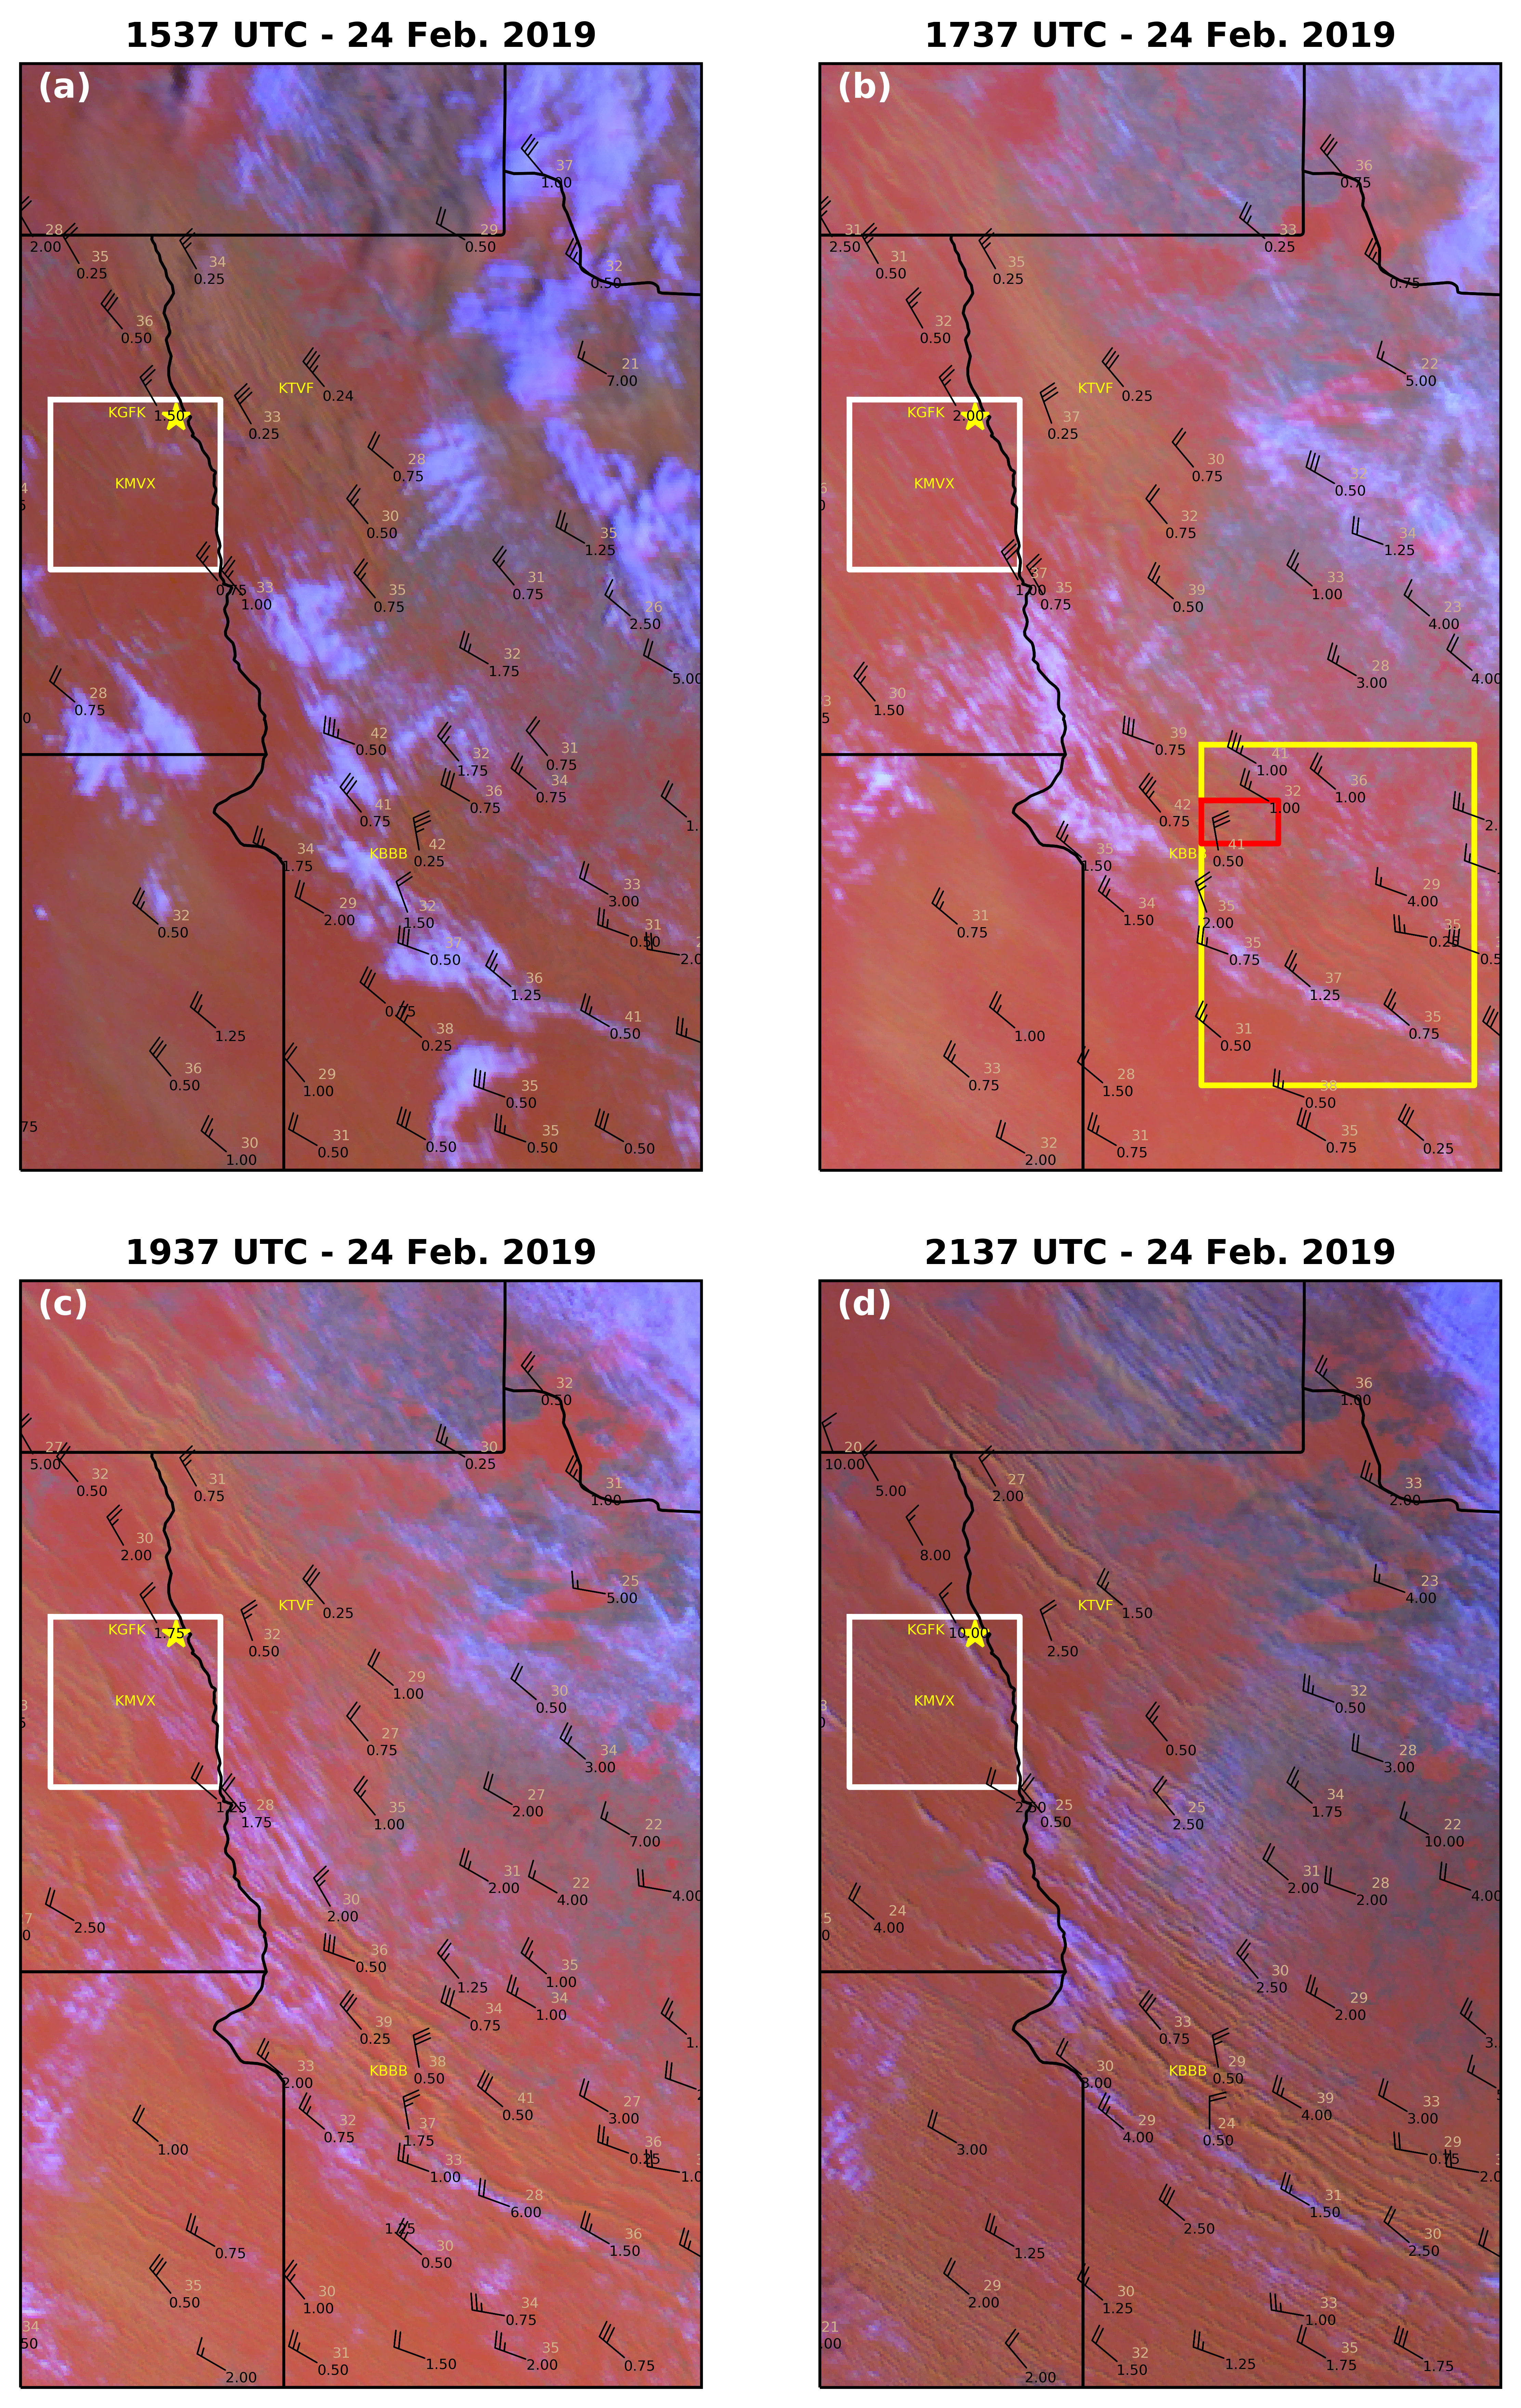

In [3]:
import warnings
warnings.simplefilter('ignore')
import h5py
from satpy import Scene
from satpy.writers import get_enhanced_image, to_image
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from metpy.calc import wind_components
from metpy.plots import StationPlot
from metpy.units import units
%matplotlib inline
#define boundaries for radar ob region
radlons = [-97.826, -96.826, -96.826, -97.826,-97.826]
radlats = [48.028, 48.028, 47.028, 47.028,48.028]

#Directories, file names, and panels
SFC_BASE_DIR = 'data/SFC/'
SAT_BASE_DIR = 'data/GOES16/'
sfc_files=['data_022419_1535.txt','data_022419_1735.txt','data_022419_1935.txt','data_022419_2135.txt']
sat_times=['20190551537137','20190551737137','20190551937137','20190552137137']
letter=['(a)','(b)','(c)','(d)']
mpl.rcParams['axes.linewidth'] = 4 #set the value globally

#Create figure 
fig = plt.figure(figsize=(10,15), dpi=600) #create fig
ax = fig.subplots(nrows=2, ncols=2,subplot_kw={'projection': ccrs.PlateCarree()})
#Loop through and create the four panels
for i in range(0, 2):
    for j in range(0, 2):

        index=2*i+j
        #Process station data using pandas
        f=SFC_BASE_DIR+sfc_files[index]
        data = pd.read_csv(f, header=0,names=['stid', 'time', 'lon', 'lat', 'air_temperature', 'dew_point_temperature',
                                      'wind_dir', 'wind_speed', 'slp', 'visibility', 'wind_gust', 'weather', 
                                      'cloud_fraction'], na_values='M')

        u, v = wind_components((data['wind_speed'].values * units.knots),
                       data['wind_dir'].values * units.degree)

        #Specify Date from filename
        sat_date=sat_times[index]
        hour=sat_date[7:11]
        #Load scene, grabs all data with given start time. For GOES16 L1B -> C01-C16
        scn = Scene(reader='abi_l1b', filenames=glob(SAT_BASE_DIR+'OR_ABI-L1b-RadC-*s'+sat_date+'*.nc'))
        scn.load(['blsn']) #load BLSN composite scheme
        new_scn = scn.resample(resampler='native') #resample to common grid
        var = get_enhanced_image(new_scn['blsn']).data #Perform enhancements to composite
        var = var.transpose('y', 'x', 'bands') #transpose data for plotting
        abi_crs = var.attrs['area'].to_cartopy_crs()
        ax[i,j].set_extent([-98, -94, 43.5, 50], crs=ccrs.PlateCarree())
        ax[i,j].imshow(var.data, extent=(var.x[0], var.x[-1], var.y[-1], var.y[0]), origin='upper',transform=abi_crs)
        ax[i,j].add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')
        ax[i,j].add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')
        ax[i,j].set_title(hour+' UTC - 24 Feb. 2019',fontweight="bold",fontsize=12)
        #Metpy,create wind barbs and annotated values (wind gusts/visibility)
        stationplot = StationPlot(ax[i,j], data['lon'].values, data['lat'].values, clip_on=True,
                                  transform=ccrs.PlateCarree(), fontsize=6)
        stationplot.plot_barb(u, v,linewidth=0.5,zorder=2)
        stationplot.plot_parameter((0.5, -0.25), data['visibility'],formatter='4.2f',fontsize=5,zorder=2)
        stationplot.plot_parameter((1, 0.75), data['wind_gust'],formatter='2.0f',color='tan',fontsize=5,zorder=2)
        #annotate a bunch of stuff
        ax[i,j].text(-97.9, 49.8, letter[index], fontsize=12,weight='bold',color="white",zorder=3)
        ax[i,j].plot(radlons, radlats, transform=ccrs.PlateCarree(),linewidth=2,color="white",zorder=1)
        ax[i,j].plot(-97.08697021,47.92184258,color='yellow',transform=ccrs.PlateCarree(),marker='*',zorder=2,markersize=10)
        ax[i,j].text(-95.6506-0.3,45.3319,'KBBB',color='yellow',transform=ccrs.PlateCarree(),fontsize=5)
        ax[i,j].text(-97.08697021-0.4,47.92184258,'KGFK',color='yellow',transform=ccrs.PlateCarree(),fontsize=5)
        ax[i,j].text(-96.1850-0.3,48.0657,'KTVF',color='yellow',transform=ccrs.PlateCarree(),fontsize=5)
        ax[i,j].text(-97.3256,47.5278,'KMVX',color='yellow',transform=ccrs.PlateCarree(),fontsize=5,ha='center',va='center')

#Add panel specific annotations    
lons = [-95.76, -94.156, -94.156, -95.76,-95.76]
lats = [46, 46, 44, 44,46]
ax[0,1].plot(lons, lats, transform=ccrs.PlateCarree(),linewidth=2,color="yellow",zorder=1)
lons = [-95.76, -95.307, -95.307, -95.76,-95.76]
lats = [45.673, 45.673, 45.42, 45.42,45.673]
ax[0,1].plot(lons, lats, transform=ccrs.PlateCarree(),linewidth=2,color="red",zorder=1)

#Adjust subplot spacing
plt.subplots_adjust(hspace = 0.1, wspace = 0.01)
#plt.savefig('KJ_MWR_2020_Fig03_final.png', dpi=600, bbox_inches='tight')
#plt.savefig('KJ_MWR_2020_Fig03_final.pdf', format='pdf', bbox_inches='tight')
plt.show()